In [ ]:
# !cd chest_xray/val
!ls

 chest_xray		    gdrive	       kaggle.json
 chest-xray-pneumonia.zip  'kaggle (1).json'   sample_data


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle (1).json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!pip install zip_files

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.3.0


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
# GCS_PATH = KaggleDatasets().get_gcs_path()


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import matplotlib.pyplot as plt
# from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

AUTOTUNE=tf.data.experimental.AUTOTUNE
# GCS_PATH=KaggleDatasets().get_gcs_path()
BATCH_SIZE=32
IMAGE_SIZE=[224,224]
EPOCHS=5

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train_path="content/chest_xray/train"
test_path="content/chest_xray/test"

In [ ]:
#Add preprocessing layer to the front of vgg
vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)

In [ ]:
#Don't train existing weights
for layer in vgg.layers:
  layer.trainable=False

In [ ]:
#Useful for getting number of classes
folders=glob('chest_xray/train/*')
print(folders)

['chest_xray/train/NORMAL', 'chest_xray/train/PNEUMONIA']


In [ ]:
#Out layers
x=Flatten()(vgg.output)
#x=Dense(1000, activation='relu')(x)
prediction=Dense(len(folders),activation='softmax')(x)

In [ ]:
#Create a model object
model= Model(inputs=vgg.input, outputs=prediction)

In [ ]:
#View of the structure of the model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
#Defining cost and optimization methods
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(rescale=1./255,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip = True)

test_datagen=ImageDataGenerator(rescale=1./255)

training_set=train_datagen.flow_from_directory('chest_xray/train',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

test_set=test_datagen.flow_from_directory('chest_xray/test',
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
#fit the model
r=model.fit_generator(
    training_set,
    validation_data=test_set,
    epochs=2,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
163/163 [==============================] - 3307s 20s/step - loss: 0.1577 - accuracy: 0.9394 - val_loss: 0.3799 - val_accuracy: 0.8782
Epoch 2/2
163/163 [==============================] - 3355s 21s/step - loss: 0.1178 - accuracy: 0.9551 - val_loss: 0.3799 - val_accuracy: 0.8942


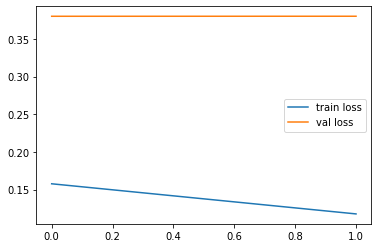

KeyError: ignored

In [ ]:
#loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
# plt.savefig('LossVal_loss')

#accuracies
plt.plot(r.history['acc'], label='train acc')
plt.plot(r.history['val_acc'], lable='val acc')
plt.legend()
plt.show()
# plt.savefig('AccVal_acc')

In [ ]:
val_datagen=ImageDataGenerator(rescale=1./255)

val_set=val_datagen.flow_from_directory('chest_xray/val',
                                               target_size=(224,224),
                                               batch_size=2,
                                               class_mode='categorical')

Found 16 images belonging to 2 classes.


In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [ ]:
loss, acc, prec, rec = model.evaluate(val_set)

8/8 [==============================] - 8s 967ms/step - loss: 0.1746 - accuracy: 0.9375


ValueError: ignored

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
# img=image.load_img('chest_xray/val/MORMAL/NORMAL2-IM-1427-0001.jpeg',target_size=(224,224))
img=image.load_img('chest_xray/test/MORMAL/IM-0001-0001.jpeg',target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
classes=model.predict(img_data)

FileNotFoundError: ignored